In [ ]:
# Force reinstall the packages to get prophet 1.2.1
!pip install --upgrade --no-deps --force-reinstall prophet==1.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [57]:
data = pd.read_csv('/content/drive/MyDrive/Tamil Nadu Case study/Data Set/Cleaned_tamil_nadu_aqi_data_29thAug.csv')
data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2024-01-01,90.77,141.06,5.36,4.85,6.93,8.44,3.24,0.59,12.86,...,202.566667,127.373333,4.0500,8.6625,2.1100,29.5,12.86,7,203.0,Very Unhealthy
1,2024-01-02,60.41,106.35,5.42,5.08,7.11,8.21,2.74,0.52,12.25,...,101.366667,104.233333,3.4250,8.8875,2.0525,26.0,12.25,7,104.0,Unhealthy for Sensitive Groups
2,2024-01-03,62.33,121.83,8.18,8.78,11.13,11.94,2.43,0.70,11.05,...,107.766667,114.553333,3.0375,13.9125,2.9850,35.0,11.05,7,115.0,Unhealthy for Sensitive Groups
3,2024-01-04,58.43,93.83,8.63,7.81,11.17,8.43,2.43,0.63,11.54,...,97.383333,93.830000,3.0375,13.9625,2.1075,31.5,11.54,7,97.0,Moderate
4,2024-01-05,52.82,83.17,7.47,6.83,9.71,9.34,2.55,0.62,11.81,...,88.033333,83.170000,3.1875,12.1375,2.3350,31.0,11.81,7,88.0,Moderate


# Task
Develop and train 7-day forecasting models for the individual concentrations of all relevant pollutants, apply the official CPCB sub-index calculation to each of the forecasted concentration values for each future day, and determine the final 7-day AQI forecast by taking the maximum of the 8 forecasted sub-indices for each respective day.

## Prepare data for forecasting

### Subtask:
Select relevant columns, convert the 'Date' column to datetime objects, and rename columns to 'ds' and 'y' as required by Prophet.


**Reasoning**:
Select relevant columns, convert the 'Date' column to datetime objects, and rename columns to 'ds' and 'y' for the 'PM2.5' pollutant as a starting point for the loop.



In [58]:
data.columns

Index(['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Temp', 'RH', 'WS', 'WD', 'SR', 'BP', 'PM2.5_SubIndex',
       'PM10_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex', 'NH3_SubIndex',
       'CO_SubIndex', 'O3_SubIndex', 'Checks', 'AQI_calculated',
       'AQI_bucket_calculated'],
      dtype='object')

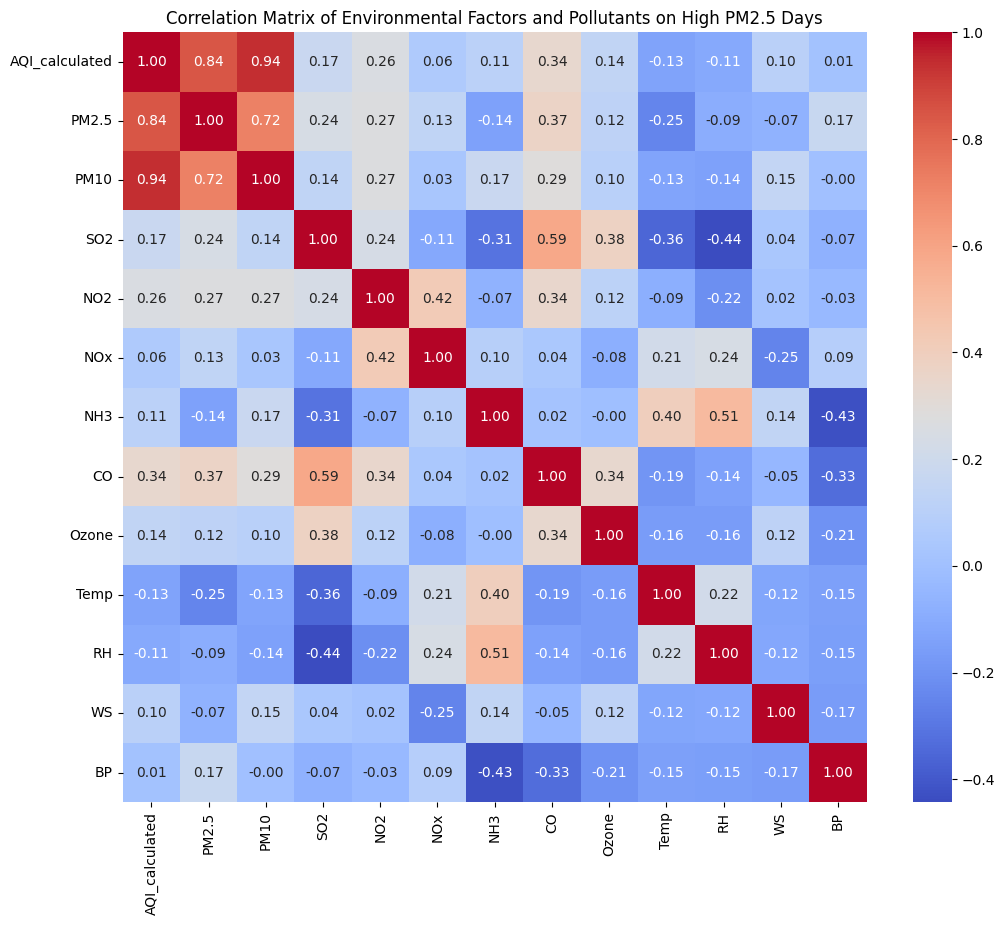

In [59]:
import seaborn as sns
plt.figure(figsize=(12, 10))
columns_to_correlate = ['AQI_calculated','PM2.5', 'PM10', 'SO2','NO2', 'NOx', 'NH3', 'CO', 'Ozone', 'Temp', 'RH', 'WS', 'BP']
correlation_matrix = data[columns_to_correlate].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Environmental Factors and Pollutants on High PM2.5 Days')
plt.show()

In [60]:
# Define the list of columns you intend to drop
all_cols_to_consider_dropping = ['WS', 'WD', 'SR', 'BP', 'PM2.5_SubIndex',
       'PM10_SubIndex', 'SO2_SubIndex', 'NOx_SubIndex', 'NH3_SubIndex',
       'CO_SubIndex', 'O3_SubIndex', 'Checks',
       'AQI_bucket_calculated']

# Filter this list to only include columns that are actually in the DataFrame
existing_cols_to_drop = [col for col in all_cols_to_consider_dropping if col in data.columns]

# Drop the existing columns
data = data.drop(columns=existing_cols_to_drop)

data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Temp,RH,AQI_calculated
0,2024-01-01,90.77,141.06,5.36,4.85,6.93,8.44,3.24,0.59,12.86,27.42,70.76,203.0
1,2024-01-02,60.41,106.35,5.42,5.08,7.11,8.21,2.74,0.52,12.25,27.78,71.11,104.0
2,2024-01-03,62.33,121.83,8.18,8.78,11.13,11.94,2.43,0.70,11.05,33.43,76.51,115.0
3,2024-01-04,58.43,93.83,8.63,7.81,11.17,8.43,2.43,0.63,11.54,27.58,77.32,97.0
4,2024-01-05,52.82,83.17,7.47,6.83,9.71,9.34,2.55,0.62,11.81,27.54,75.04,88.0


In [61]:
print("Size of the dataset (rows, columns):")
print(data.shape)

Size of the dataset (rows, columns):
(638, 13)


# Vector Error Correction Model

In [62]:
data.columns

Index(['Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO',
       'Ozone', 'Temp', 'RH', 'AQI_calculated'],
      dtype='object')

In [63]:
selected_vars = data[['Date', 'AQI_calculated', 'PM2.5', 'PM10', 'NH3', 'RH']].copy()
selected_vars['Date'] = pd.to_datetime(selected_vars['Date'])
selected_vars = selected_vars.set_index('Date')
display(selected_vars.head())

,AQI_calculated,PM2.5,PM10,NH3,RH
Date,,,,,
2024-01-01,203.0,90.77,141.06,8.44,70.76
2024-01-02,104.0,60.41,106.35,8.21,71.11
2024-01-03,115.0,62.33,121.83,11.94,76.51
2024-01-04,97.0,58.43,93.83,8.43,77.32
2024-01-05,88.0,52.82,83.17,9.34,75.04


In [64]:
train_len = int(np.ceil(len(selected_vars)*0.75))
train_vecm =selected_vars[0:train_len]
test_vecm=selected_vars[train_len:]

print('Training data shape (selected variables):', train_vecm.shape)
print('Testing data shape (selected variables):', test_vecm.shape)

Training data shape (selected variables): (479, 5)
Testing data shape (selected variables): (159, 5)


In [65]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [66]:
vecm_order_results = select_order(train_vecm, maxlags=10, deterministic='li')
print(vecm_order_results.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        17.27      17.58*   3.178e+07      17.40*
1        17.19       17.72   2.923e+07       17.40
2       17.15*       17.90  2.799e+07*       17.44
3        17.20       18.18   2.965e+07       17.59
4        17.24       18.44   3.072e+07       17.71
5        17.24       18.66   3.082e+07       17.80
6        17.29       18.93   3.235e+07       17.94
7        17.28       19.15   3.220e+07       18.02
8        17.32       19.40   3.339e+07       18.14
9        17.34       19.64   3.397e+07       18.24
10       17.37       19.89   3.512e+07       18.36
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [67]:
order_res = select_order(train_vecm, maxlags=10, deterministic="li")
lag_order = order_res.aic  # or .fpe / .bic / .hqic
print("Chosen lag_order (k_ar_diff):", lag_order)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Chosen lag_order (k_ar_diff): 2


In [68]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
rank_res = select_coint_rank(train_vecm, det_order=0, k_ar_diff=lag_order, method='trace')
rank = rank_res.rank
print("Chosen cointegration rank:", rank)

Chosen cointegration rank: 5


In [69]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Fit the VECM model using the determined lag order and cointegration rank
vecm_model = VECM(train_vecm, k_ar_diff=lag_order, coint_rank=rank, deterministic='li')
vecm_fit = vecm_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [70]:
# Print the summary of the fitted model
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation AQI_calculated
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.AQI_calculated     0.3530      0.180      1.957      0.050      -0.000       0.706
L1.PM2.5             -0.0395      0.242     -0.163      0.870      -0.514       0.435
L1.PM10              -0.2830      0.152     -1.868      0.062      -0.580       0.014
L1.NH3               -0.2008      0.756     -0.266      0.790      -1.682       1.280
L1.RH                -1.1359      0.401     -2.830      0.005      -1.923      -0.349
L2.AQI_calculated     0.1258      0.149      0.844      0.399      -0.166       0.418
L2.PM2.5             -0.4295      0.214     -2.010      0.044      -0.848      -0.011
L2.PM10              -0.0934      0.133     -0.705      0.481      -0.353       0.166
L2.NH3               -0.2415      0.729     -0

In [71]:
# Make predictions on the test data
vecm_forecast_array = vecm_fit.predict(steps=len(test_vecm))

# Convert the NumPy array to a pandas DataFrame
vecm_forecast_df = pd.DataFrame(vecm_forecast_array)

# Assign column names and index
vecm_forecast_df.columns = test_vecm.columns
vecm_forecast_df.index = test_vecm.index

# Calculate RMSE
vecm_rmse = np.sqrt(mean_squared_error(test_vecm['AQI_calculated'], vecm_forecast_df['AQI_calculated']))

# Calculate MAE for the VECM model
vecm_mae = mean_absolute_error(test_vecm['AQI_calculated'], vecm_forecast_df['AQI_calculated'])

# Print the RSME,MAE
print(f"VECM Model MAE: {vecm_mae:.4f}")
print(f"VECM Model RMSE: {vecm_rmse:.4f}")

VECM Model MAE: 23.3482
VECM Model RMSE: 29.1127


# VARMA

Divide the selected variables data into Training & Testing

In [72]:
# Define the split point (e.g., 80% for training, 20% for testing)
train_varma_len = int(len(selected_vars) * 0.8)
train_varma, test_varma = selected_vars[0:train_varma_len], selected_vars[train_varma_len:]

print('Training data shape (selected variables for VARMA):', train_varma.shape)
print('Testing data shape (selected variables for VARMA):', test_varma.shape)

Training data shape (selected variables for VARMA): (510, 5)
Testing data shape (selected variables for VARMA): (128, 5)


Determine the optimal order for the VARMA model using the selected variables

Apply the VARMA model with the selected order

In [73]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [74]:
# Apply VARMA model
varma_model = VARMAX(train_varma, order=(3,0), enforce_stationarity=False, enforce_invertibility=False)
varma_results = varma_model.fit(disp=False)
print(varma_results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                          Statespace Model Results                                          
Dep. Variable:     ['AQI_calculated', 'PM2.5', 'PM10', 'NH3', 'RH']   No. Observations:                  510
Model:                                                       VAR(3)   Log Likelihood               -7915.760
                                                        + intercept   AIC                          16021.519
Date:                                              Fri, 07 Nov 2025   BIC                          16423.788
Time:                                                      19:28:17   HQIC                         16179.235
Sample:                                                  01-01-2024                                         
                                                       - 05-24-2025                                         
Covariance Type:                                                opg                                         
Ljung-Box (L1) (Q):

Forecast on the test data and evaluate using RMSE and MAPE

In [75]:
# Make forecast
varma_forecast = varma_results.forecast(steps=len(test_varma))
varma_forecast_df = pd.DataFrame(varma_forecast, index=test_varma.index, columns=test_varma.columns)

# Calculate RMSE for 'AQI_calculated'
rmse_varma = np.sqrt(mean_squared_error(test_varma['AQI_calculated'], varma_forecast_df['AQI_calculated']))
print('VARMA RMSE:', rmse_varma)

# Calculate MAPE for 'AQI_calculated'
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero in case of actual values being 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan

mae_varma = mean_absolute_percentage_error(test_varma['AQI_calculated'], varma_forecast_df['AQI_calculated'])
print('VARMA MAE:', mae_varma)

VARMA RMSE: 30.21607321652001
VARMA MAE: 31.639613470765138


# Multivariate LSTM Model

In [76]:
# STEP 1: Preprocessing for Multivariate LSTM
# ==========================================
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns for multivariate LSTM (AQI and key pollutants)
multivariate_data = data[['AQI_calculated', 'PM2.5', 'PM10', 'NH3', 'RH']].values

# Scale between 0 and 1
scaler_multi = MinMaxScaler(feature_range=(0,1))
multivariate_scaled = scaler_multi.fit_transform(multivariate_data)

# Function to create time-lagged sequences for multivariate data
def create_sequences_multi(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), :]) # Include all features in X
        y.append(dataset[i+time_step, 0]) # Predict only AQI_calculated (index 0)
    return np.array(X), np.array(y)

time_step_multi = 30  # using past 30 days to predict next day
X_multi, y_multi = create_sequences_multi(multivariate_scaled, time_step_multi)

# Reshape for LSTM [samples, time_steps, features] - already in correct shape
# X_multi = X_multi.reshape(X_multi.shape[0], X_multi.shape[1], X_multi.shape[2])

# Train-test split
train_size_multi = int(len(X_multi) * 0.8)
X_train_multi, X_test_multi = X_multi[:train_size_multi], X_multi[train_size_multi:]
y_train_multi, y_test_multi = y_multi[:train_size_multi], y_multi[train_size_multi:]

print(f"Shape of X_train_multi: {X_train_multi.shape}")
print(f"Shape of y_train_multi: {y_train_multi.shape}")
print(f"Shape of X_test_multi: {X_test_multi.shape}")
print(f"Shape of y_test_multi: {y_test_multi.shape}")

Shape of X_train_multi: (485, 30, 5)
Shape of y_train_multi: (485,)
Shape of X_test_multi: (122, 30, 5)
Shape of y_test_multi: (122,)


In [77]:
# ==========================================
# STEP 2: Build Multivariate LSTM model
# ==========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_multi = Sequential()
# Input shape is now (time_step, number of features)
model_multi.add(LSTM(50, return_sequences=True, input_shape=(time_step_multi, X_train_multi.shape[2])))
model_multi.add(Dropout(0.2))
model_multi.add(LSTM(50, return_sequences=False))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(1)) # Predicting a single value (AQI)

model_multi.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_multi = model_multi.fit(X_train_multi, y_train_multi,
                              validation_data=(X_test_multi, y_test_multi),
                              epochs=20, batch_size=32, verbose=1)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0206 - val_loss: 0.0152
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0145 - val_loss: 0.0088
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Multivariate Train RMSE: 28.31
Multivariate Test RMSE: 46.62


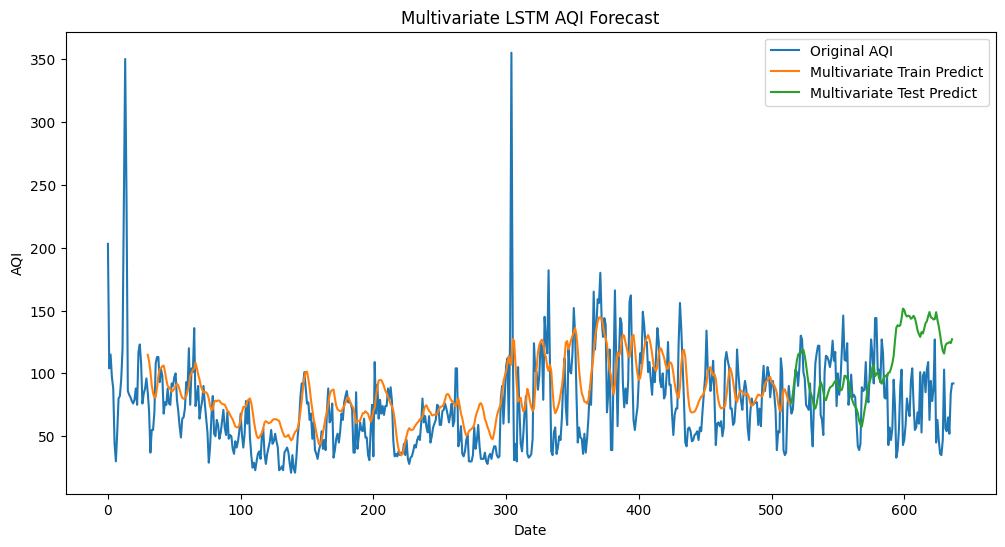

In [78]:
# ==========================================
# STEP 3: Evaluate and Forecast Multivariate LSTM
# ==========================================
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Predictions
train_predict_multi = model_multi.predict(X_train_multi)
test_predict_multi = model_multi.predict(X_test_multi)

# Inverse transform back to original scale
# Need to create a dummy array with the same number of features as the original data
dummy_train = np.zeros((len(train_predict_multi), multivariate_data.shape[1]))
dummy_train[:, 0] = train_predict_multi[:, 0]
train_predict_multi_orig = scaler_multi.inverse_transform(dummy_train)[:, 0]

dummy_test = np.zeros((len(test_predict_multi), multivariate_data.shape[1]))
dummy_test[:, 0] = test_predict_multi[:, 0]
test_predict_multi_orig = scaler_multi.inverse_transform(dummy_test)[:, 0]


dummy_ytrain = np.zeros((len(y_train_multi), multivariate_data.shape[1]))
dummy_ytrain[:, 0] = y_train_multi
y_train_multi_orig = scaler_multi.inverse_transform(dummy_ytrain)[:, 0]

dummy_ytest = np.zeros((len(y_test_multi), multivariate_data.shape[1]))
dummy_ytest[:, 0] = y_test_multi
y_test_multi_orig = scaler_multi.inverse_transform(dummy_ytest)[:, 0]


# Calculate RMSE
train_rmse_multi = math.sqrt(mean_squared_error(y_train_multi_orig, train_predict_multi_orig))
test_rmse_multi = math.sqrt(mean_squared_error(y_test_multi_orig, test_predict_multi_orig))

print(f'Multivariate Train RMSE: {train_rmse_multi:.2f}')
print(f'Multivariate Test RMSE: {test_rmse_multi:.2f}')

# Plot results
plt.figure(figsize=(12,6))
# Adjust the indices for plotting to match the original data index
train_plot_index = data.index[time_step_multi : train_size_multi + time_step_multi]
test_plot_index = data.index[train_size_multi + time_step_multi : train_size_multi + time_step_multi + len(test_predict_multi_orig)]

plt.plot(data.index, data['AQI_calculated'], label="Original AQI")
plt.plot(train_plot_index, train_predict_multi_orig, label="Multivariate Train Predict")
plt.plot(test_plot_index, test_predict_multi_orig, label="Multivariate Test Predict")
plt.legend()
plt.title("Multivariate LSTM AQI Forecast")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for the Multivariate LSTM model
lstm_mae = mean_absolute_error(y_test_multi_orig, test_predict_multi_orig)

# Print the MAE
print(f"Multivariate Test MAE: {lstm_mae:.4f}")

Multivariate Test MAE: 37.2368


# Compare the Models

In [80]:
# Create a dictionary to store the results
results = {
    'Model': ['VECM', 'VARMA', 'LSTM (Multivariante)'],
    'RMSE': [vecm_rmse, rmse_varma, test_rmse_multi],
    'MAE': [vecm_mae, mae_varma, lstm_mae]
}

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print("Model Performance Summary:")
display(results_df)

Model Performance Summary:


,Model,RMSE,MAE
0,VECM,29.112667,23.348242
1,VARMA,30.216073,31.639613
2,LSTM (Multivariante),46.622657,37.236838


# prophet with individual pollutant forcast

In [81]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

In [82]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

In [83]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

In [84]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

In [85]:
# NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

In [86]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

In [87]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

In [88]:
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone']
forecasts = {}

for pollutant in pollutants:
    df_prophet = data[['Date', pollutant]].copy()
    df_prophet['Date'] = pd.to_datetime(df_prophet['Date'])
    df_prophet.rename(columns={'Date': 'ds', pollutant: 'y'}, inplace=True)

    model = Prophet()
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=7, freq='D')
    forecast = model.predict(future)

    forecasts[pollutant] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

In [89]:
# Define a dictionary mapping pollutant names to their respective sub-index functions
subindex_functions = {
    'PM2.5': get_PM25_subindex,
    'PM10': get_PM10_subindex,
    'SO2': get_SO2_subindex,
    'NOx': get_NOx_subindex,
    'NH3': get_NH3_subindex,
    'CO': get_CO_subindex,
    'Ozone': get_O3_subindex
}

for pollutant, forecast_df in forecasts.items():
    if pollutant in subindex_functions:
        subindex_col_name = f'{pollutant}_SubIndex'
        forecast_df[subindex_col_name] = forecast_df['yhat'].apply(subindex_functions[pollutant])

display(forecasts)

{'PM2.5':             ds       yhat  yhat_lower  yhat_upper  PM2.5_SubIndex
 638 2025-09-30  12.803112   -7.913153   33.219684       21.338519
 639 2025-10-01  12.617827   -8.040177   31.341848       21.029711
 640 2025-10-02  13.158139   -6.052404   35.690824       21.930231
 641 2025-10-03  12.533075   -7.017560   31.412135       20.888459
 642 2025-10-04  10.942603  -10.335764   30.256502       18.237672
 643 2025-10-05  11.149823   -8.971950   32.537570       18.583039
 644 2025-10-06  11.457796   -9.206434   32.051009       19.096326,
 'PM10':             ds       yhat  yhat_lower  yhat_upper  PM10_SubIndex
 638 2025-09-30  87.757964   52.687976  123.725241      87.757964
 639 2025-10-01  89.814049   54.474490  130.169193      89.814049
 640 2025-10-02  89.578071   50.357735  127.636273      89.578071
 641 2025-10-03  88.827714   53.554227  129.625845      88.827714
 642 2025-10-04  85.262043   46.303255  120.426693      85.262043
 643 2025-10-05  81.805089   45.145920  118.959726

In [90]:
daily_aqi_forecasts = []
forecast_dates = forecasts['PM2.5']['ds'] # Assuming all forecast dataframes have the same dates

for date in forecast_dates:
    daily_subindices = []
    for pollutant in subindex_functions.keys():
        forecast_df = forecasts[pollutant]
        subindex_col_name = f'{pollutant}_SubIndex'
        if subindex_col_name in forecast_df.columns:
             # Find the row for the current date and extract the sub-index value
            subindex_value = forecast_df[forecast_df['ds'] == date][subindex_col_name].iloc[0]
            daily_subindices.append(subindex_value)

    max_subindex = max(daily_subindices)
    daily_aqi_forecasts.append({'Date': date, 'Forecasted_AQI': max_subindex})

forecasted_aqi_df = pd.DataFrame(daily_aqi_forecasts)
display(forecasted_aqi_df)

,Date,Forecasted_AQI
0,2025-09-30,87.757964
1,2025-10-01,89.814049
2,2025-10-02,89.578071
3,2025-10-03,88.827714
4,2025-10-04,85.262043
5,2025-10-05,81.805089
6,2025-10-06,85.774245


In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Actual AQI values provided by the user
actual_aqi_values = [94, 82, 72, 86, 73, 82, 73]

# Dates for the 7-day forecast (from the forecasted_aqi_df)
forecast_dates = forecasted_aqi_df['Date']

# Create a DataFrame for the actual AQI values
actual_aqi_df = pd.DataFrame({'Date': forecast_dates, 'Actual_AQI': actual_aqi_values})

# Merge the actual and forecasted AQI values
aqi_comparison_df = pd.merge(actual_aqi_df, forecasted_aqi_df, on='Date', how='inner')

# Calculate RMSE and MAE
if not aqi_comparison_df.empty:
    rmse_aqi_7day = np.sqrt(mean_squared_error(aqi_comparison_df['Actual_AQI'], aqi_comparison_df['Forecasted_AQI']))
    mae_aqi_7day = mean_absolute_error(aqi_comparison_df['Actual_AQI'], aqi_comparison_df['Forecasted_AQI'])
    print(f"RMSE for 7-day AQI forecast: {rmse_aqi_7day}")
    print(f"MAE for 7-day AQI forecast: {mae_aqi_7day}")
else:
    print("Could not calculate RMSE and MAE. Dates in actual and forecasted AQI do not match.")

RMSE for 7-day AQI forecast: 10.216121273366102
MAE for 7-day AQI forecast: 8.527581224324251


# 7-day period forecast for individual model

In [92]:
# Provided actual AQI values for the 7-day forecast period (2025-09-30 to 2025-10-06) taken from AQI website
actual_aqi_7day = np.array([94, 82, 72, 86, 73, 82, 73])

In [93]:
# --- VECM 7-day Forecast ---
# Make predictions for the next 7 steps
vecm_forecast_7day_array = vecm_fit.predict(steps=7)

# Convert the NumPy array to a pandas DataFrame for AQI
vecm_aqi_forecast_7day = pd.DataFrame(vecm_forecast_7day_array, columns=test_vecm.columns).iloc[:, 0].values

In [94]:
# --- VARMA 7-day Forecast ---
# Make forecast for the next 7 steps
varma_forecast_7day = varma_results.forecast(steps=7)
# Extract the AQI forecast (assuming AQI_calculated is the first column)
varma_aqi_forecast_7day = varma_forecast_7day.iloc[:, 0].values

In [95]:
# --- LSTM (Multivariate) 7-day Forecast ---
# To forecast 7 days with LSTM, we need to predict one step at a time,
# using the previous prediction as part of the input sequence for the next prediction.
# This is a simplified approach; a more robust method would involve
# multi-step forecasting strategies.

lstm_aqi_forecast_7day = []
last_sequence = X_test_multi[-1].copy() # Start with the last test sequence

for _ in range(7):
    # Reshape the last sequence to be (1, time_steps, features) for prediction
    input_seq = last_sequence.reshape(1, time_step_multi, X_train_multi.shape[2])

    # Predict the next step
    predicted_scaled = model_multi.predict(input_seq, verbose=0)[0, 0]

    # Inverse transform the prediction
    dummy_pred = np.zeros((1, multivariate_data.shape[1]))
    dummy_pred[0, 0] = predicted_scaled
    predicted_orig = scaler_multi.inverse_transform(dummy_pred)[0, 0]

    lstm_aqi_forecast_7day.append(predicted_orig)

    # Update the last sequence: remove the first time step and add the new predicted (scaled) AQI and last available scaled values for other features
    # For simplicity, using the last scaled values of other features from the test set
    last_scaled_other_features = multivariate_scaled[-(len(X_test_multi) + 1 + 7 - _):][0, 1:] # Get the corresponding original row and take features from index 1 onwards
    new_time_step = np.insert(last_scaled_other_features, 0, predicted_scaled) # Insert predicted AQI at the beginning
    last_sequence = np.vstack((last_sequence[1:], new_time_step)) # Append the new time step


lstm_aqi_forecast_7day = np.array(lstm_aqi_forecast_7day)

In [96]:
# --- Calculate RMSE and MAE for 7-day forecasts ---

vecm_rmse_7day = np.sqrt(mean_squared_error(actual_aqi_7day, vecm_aqi_forecast_7day))
vecm_mae_7day = mean_absolute_error(actual_aqi_7day, vecm_aqi_forecast_7day)

varma_rmse_7day = np.sqrt(mean_squared_error(actual_aqi_7day, varma_aqi_forecast_7day))
varma_mae_7day = mean_absolute_error(actual_aqi_7day, varma_aqi_forecast_7day)

lstm_rmse_7day = np.sqrt(mean_squared_error(actual_aqi_7day, lstm_aqi_forecast_7day))
lstm_mae_7day = mean_absolute_error(actual_aqi_7day, lstm_aqi_forecast_7day)

# comparision of the 7-day forcast fo all the models

In [100]:
# --- Display Results ---
# Extract the 'Forecasted_AQI' values from the list of dictionaries
prophet_aqi_forecast_7day_list = [item['Forecasted_AQI'] for item in daily_aqi_forecasts]

print("\n7-Day Forecast Results (2025-09-30 to 2025-10-06):")
print(f"Actual AQI: {actual_aqi_7day}")
print(f"Prophet (Individual Pollutants) Forecast: {np.array(prophet_aqi_forecast_7day_list).round(2)}")
print(f"VECM Forecast: {vecm_aqi_forecast_7day.round(2)}")
print(f"VARMA Forecast: {varma_aqi_forecast_7day.round(2)}")
print(f"LSTM (Multivariate) Forecast: {lstm_aqi_forecast_7day.round(2)}")


7-Day Forecast Results (2025-09-30 to 2025-10-06):
Actual AQI: [94 82 72 86 73 82 73]
Prophet (Individual Pollutants) Forecast: [87.76 89.81 89.58 88.83 85.26 81.81 85.77]
VECM Forecast: [72.44 74.69 76.06 78.93 81.28 83.08 84.34]
VARMA Forecast: [47.07 57.66 61.5  60.36 59.74 61.03 62.3 ]
LSTM (Multivariate) Forecast: [127.16 141.18 148.3  149.63 146.73 139.3  131.85]


In [98]:
print("\nModel Performance Summary for 7-Day Forecast:")
results_7day = {
    'Model': ['Prophet (Individual Pollutants)', 'VECM', 'VARMA', 'LSTM (Multivariate)'],
    'RMSE (7-day)': [rmse_aqi_7day, vecm_rmse_7day, varma_rmse_7day, lstm_rmse_7day],
    'MAE (7-day)': [mae_aqi_7day, vecm_mae_7day, varma_mae_7day, lstm_mae_7day]
}
results_7day_df = pd.DataFrame(results_7day)
display(results_7day_df)


Model Performance Summary for 7-Day Forecast:


,Model,RMSE (7-day),MAE (7-day)
0,Prophet (Individual Pollutants),10.216121,8.527581
1,VECM,10.575346,8.670761
2,VARMA,24.763243,21.762618
3,LSTM (Multivariate),61.707695,60.306841
